In [1]:
import torch
import random
import argparse
import pandas as pd
import utils

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loss_functions import LabelSmoothing
from transformers import RobertaTokenizer
random.seed(0)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [2]:
data_path = 'C:/Users/xiuyu/nlu/data/AgreementDataset/'
output_path = 'C:/Users/xiuyu/nlu/'

In [3]:
df = pd.read_csv(
    'C:/Users/xiuyu/nlu/data/AgreementDataset/agreement_dataset_valid_tweets.tsv', sep='\t')
df

,Unnamed: 0,text,agreement_level,annotation,domain,label
0,0,I hate y’all. I hate Texas especially y’all du...,A++,O++,BLM,1
1,1,RT @Cashin_Dashin: Now pass bills and laws tha...,A++,N++,BLM,0
2,2,@YourAnonNews I guess they should ask #Anonymous!,A+,N+,BLM,0
3,3,Drew Brees gives his personal opinion on how h...,A++,N++,BLM,0
4,4,Fuck this guy. @TuckerCarlson is what happens ...,A++,O++,BLM,1
...,...,...,...,...,...,...
6812,6812,@JennGonza_ @JoeBiden get ready to cry in two ...,A++,N++,Elections2020,0
6813,6813,@stevenman47 @Adrienne1001 @EthTechUSA @Kamala...,A+,N+,Elections2020,0
6814,6814,RT @freddyatton: —((( #Top10Reasons2DumpTrump ...,A+,N+,Elections2020,0
6815,6815,@realDonaldTrump and @JoeBiden give the Americ...,A++,N++,Elections2020,0


In [4]:
df = df.drop(['Unnamed: 0'], axis=1)
df

,text,agreement_level,annotation,domain,label
0,I hate y’all. I hate Texas especially y’all du...,A++,O++,BLM,1
1,RT @Cashin_Dashin: Now pass bills and laws tha...,A++,N++,BLM,0
2,@YourAnonNews I guess they should ask #Anonymous!,A+,N+,BLM,0
3,Drew Brees gives his personal opinion on how h...,A++,N++,BLM,0
4,Fuck this guy. @TuckerCarlson is what happens ...,A++,O++,BLM,1
...,...,...,...,...,...
6812,@JennGonza_ @JoeBiden get ready to cry in two ...,A++,N++,Elections2020,0
6813,@stevenman47 @Adrienne1001 @EthTechUSA @Kamala...,A+,N+,Elections2020,0
6814,RT @freddyatton: —((( #Top10Reasons2DumpTrump ...,A+,N+,Elections2020,0
6815,@realDonaldTrump and @JoeBiden give the Americ...,A++,N++,Elections2020,0


In [5]:
# Discard items with less than 5 words in text.
df = df[df.text.str.len() >= 5]

In [6]:
df

,text,agreement_level,annotation,domain,label
0,I hate y’all. I hate Texas especially y’all du...,A++,O++,BLM,1
1,RT @Cashin_Dashin: Now pass bills and laws tha...,A++,N++,BLM,0
2,@YourAnonNews I guess they should ask #Anonymous!,A+,N+,BLM,0
3,Drew Brees gives his personal opinion on how h...,A++,N++,BLM,0
4,Fuck this guy. @TuckerCarlson is what happens ...,A++,O++,BLM,1
...,...,...,...,...,...
6812,@JennGonza_ @JoeBiden get ready to cry in two ...,A++,N++,Elections2020,0
6813,@stevenman47 @Adrienne1001 @EthTechUSA @Kamala...,A+,N+,Elections2020,0
6814,RT @freddyatton: —((( #Top10Reasons2DumpTrump ...,A+,N+,Elections2020,0
6815,@realDonaldTrump and @JoeBiden give the Americ...,A++,N++,Elections2020,0


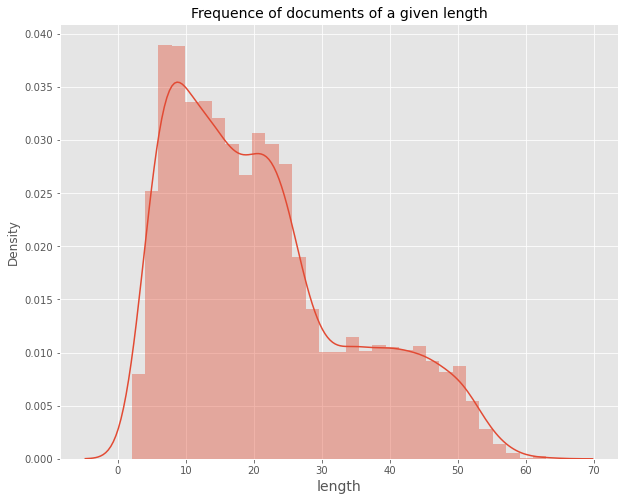

In [23]:
# Plot histogram with the length.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = df['text'].apply(lambda x: len(x.split()))
sns.distplot(df['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

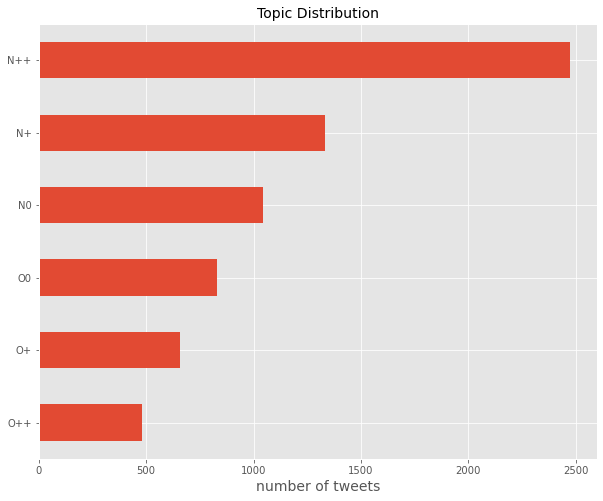

In [8]:
# Plot histogram 

plt.figure(figsize=(10, 8))
plt.title('Topic Distribution', fontsize=14)
df.annotation.value_counts().sort_values().plot(kind = 'barh')
plt.xlabel('number of tweets', fontsize=14)
None

In [24]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
df['word count'] = df['text'].apply(word_count)
df.head(3)

,text,agreement_level,annotation,domain,label,length,word count
0,I hate y’all. I hate Texas especially y’all du...,A++,O++,BLM,1,13,13
1,RT @Cashin_Dashin: Now pass bills and laws tha...,A++,N++,BLM,0,13,13
2,@YourAnonNews I guess they should ask #Anonymous!,A+,N+,BLM,0,7,7


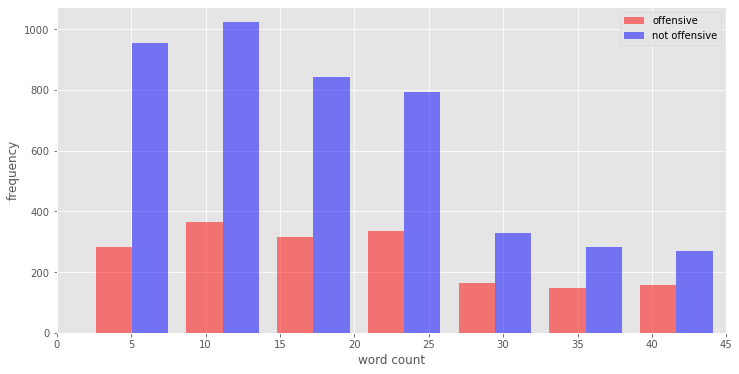

In [25]:
# plot word count distribution for both positive and negative sentiments
x = df['word count'][df.label == 1]
y = df['word count'][df.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['offensive','not offensive'])
plt.legend(loc='upper right')

In [9]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [10]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)
cuda:0

cuda:0


In [11]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'text' : ('text', text_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path=f"{data_path}/agreement_dataset_valid_tweets.tsv", 
                                                   format='TSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='label')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.text), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [12]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [13]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask,return_dict=False)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x

In [14]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [15]:
# Training Function

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)

                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [16]:
# Main training loop
NUM_EPOCHS = 6
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)


======================= Start pretraining ==============================
Epoch [1/6], global step [299/1794], PT Loss: 0.6302, Val Loss: 0.6081
Epoch [2/6], global step [598/1794], PT Loss: 0.6153, Val Loss: 0.6129
Epoch [3/6], global step [897/1794], PT Loss: 0.6122, Val Loss: 0.6037
Epoch [4/6], global step [1196/1794], PT Loss: 0.6078, Val Loss: 0.6027
Epoch [5/6], global step [1495/1794], PT Loss: 0.6068, Val Loss: 0.5995
Epoch [6/6], global step [1794/1794], PT Loss: 0.6052, Val Loss: 0.5989
Pre-training done!


In [17]:
NUM_EPOCHS = 12
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

======================= Start training =================================
Epoch [1/12], global step [299/3588], Train Loss: 0.6048, Valid Loss: 0.5967
Epoch [2/12], global step [598/3588], Train Loss: 0.5989, Valid Loss: 0.5733
Epoch [3/12], global step [897/3588], Train Loss: 0.4973, Valid Loss: 0.3944
Epoch [4/12], global step [1196/3588], Train Loss: 0.4049, Valid Loss: 0.3794
Epoch [5/12], global step [1495/3588], Train Loss: 0.3718, Valid Loss: 0.3781
Epoch [6/12], global step [1794/3588], Train Loss: 0.3528, Valid Loss: 0.3805
Epoch [7/12], global step [2093/3588], Train Loss: 0.3316, Valid Loss: 0.3932
Epoch [8/12], global step [2392/3588], Train Loss: 0.3091, Valid Loss: 0.4037
Epoch [9/12], global step [2691/3588], Train Loss: 0.3003, Valid Loss: 0.4090
Epoch [10/12], global step [2990/3588], Train Loss: 0.2966, Valid Loss: 0.4088
Epoch [11/12], global step [3289/3588], Train Loss: 0.2931, Valid Loss: 0.4025
Epoch [12/12], global step [3588/3588], Train Loss: 0.2755, Valid Loss

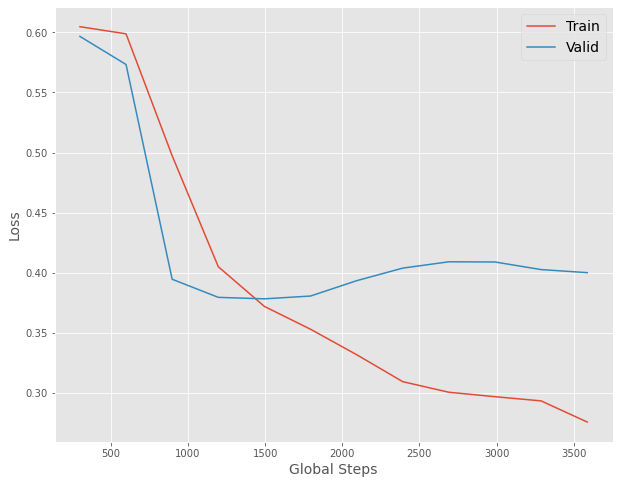

In [18]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [19]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Offensive', 'Non-offensive'])
    ax.yaxis.set_ticklabels(['Offensive', 'Non-offensive'])

Classification Report:
              precision    recall  f1-score   support

           1     0.6720    0.6412    0.6563       393
           0     0.8574    0.8733    0.8653       971

    accuracy                         0.8065      1364
   macro avg     0.7647    0.7573    0.7608      1364
weighted avg     0.8040    0.8065    0.8051      1364



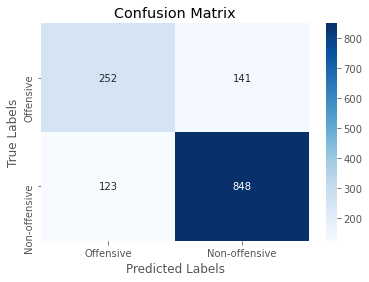

In [20]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)

In [21]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

4772
681
1364
